# Route smoothing

Notes on route smoothing.

In [1]:
from wrcapi_rallydj.data_api import WRCDataAPIClient
import pandas as pd

wrc = WRCDataAPIClient(usegeo=True)
r = wrc.get_rallies_data(2025, typ="WRC", as_dict=True)[3] # typ can be ERC, WRC
geostages = wrc.read_kmlfile(r["kmlfile"])

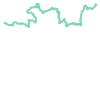

In [2]:
geostages.iloc[2].geometry

## Via claude.ai and chatgpt

In [ ]:

import osmnx as ox


def enhance_route_resolution_osm(
    geodf, point_spacing_meters=10, route_simplify_tolerance=None, use_osm=True
):
    """
    Enhance route resolution by adding points at regular meter intervals while PRESERVING original route points.
    
    Args:
        geodf: GeoDataFrame containing LineString geometries representing routes
        point_spacing_meters: Distance between points in meters (default 10m)
        route_simplify_tolerance: Optional tolerance for simplifying the route after enhancement
        use_osm: Whether to use OSM data for route enhancement (if False, just does regular spacing)
        
    Returns:
        Enhanced GeoDataFrame with more detailed route geometries
    """
    import osmnx as ox
    import geopandas as gpd
    import numpy as np
    from shapely.geometry import LineString, Point, MultiLineString

    def get_osm_roads_in_bbox(bounds, buffer_deg):
        """Get OSM road network within the bounds of a route"""
        minx, miny, maxx, maxy = bounds
        # Add buffer to ensure we capture nearby roads
        bbox = (
            miny - buffer_deg,  # south
            minx - buffer_deg,  # west
            maxy + buffer_deg,  # north
            maxx + buffer_deg,  # east
        )

        try:
            # Get all highway features
            roads = ox.features_from_bbox(bbox, {"highway": True})
            return roads
        except Exception as e:
            print(f"Error fetching OSM data: {e}")
            return None

    def enhance_line_with_regular_points(line, spacing_meters, roads=None, buffer_deg=0.0005):
        """
        Enhance a LineString with points at regular meter intervals while preserving original points.
        
        If roads is provided, also adds points from OSM road network.
        """
        # Ensure we're working with a proper LineString
        if not isinstance(line, LineString):
            print(f"Expected LineString, got {type(line)}")
            return line

        # Check if line is valid
        if not line.is_valid:
            print("Invalid LineString, attempting to fix...")
            try:
                line = line.buffer(0).boundary
                if not isinstance(line, LineString):
                    print("Could not fix LineString, returning original")
                    return line
            except Exception:
                return line

        # Handle empty or near-empty linestrings
        if len(list(line.coords)) < 2:
            print("LineString has fewer than 2 points, cannot enhance")
            return line

        # Original route points - these are GROUND TRUTH and must be preserved exactly
        try:
            # Make sure we use only x,y coordinates
            original_points = [(float(p[0]), float(p[1])) for p in line.coords]
        except Exception as e:
            print(f"Error extracting coordinates: {e}")
            return line

        try:
            # Create a GeoDataFrame with the line for projection to UTM
            line_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")

            # Get the centroid of the line to determine UTM zone
            centroid = line.centroid
            center_gdf = gpd.GeoDataFrame(geometry=[centroid], crs="EPSG:4326")

            # Determine the appropriate UTM CRS for accurate measurements
            utm_crs = center_gdf.estimate_utm_crs()

            # Project line to UTM for accurate measurements
            line_utm = line_gdf.to_crs(utm_crs).geometry.iloc[0]

            # Get total line length in meters
            total_length = line_utm.length
        except Exception as e:
            print(f"Error projecting to UTM: {e}")
            return line

        # Add OSM road points if available
        osm_points = []
        if use_osm and roads is not None and not roads.empty:
            try:
                # Extract all valid geometries from the roads
                road_lines = []
                for geom in roads.geometry:
                    if geom.geom_type == "LineString":
                        road_lines.append(geom)
                    elif geom.geom_type == "MultiLineString":
                        road_lines.extend(list(geom.geoms))

                # Create a buffer around our route line
                route_buffer = line.buffer(buffer_deg)

                # For each segment in the original route
                for i in range(len(original_points) - 1):
                    # Create a LineString for this segment
                    segment = LineString([original_points[i], original_points[i + 1]])
                    segment_buffer = segment.buffer(buffer_deg)

                    # Find OSM roads that might provide additional detail for this segment
                    for road in road_lines:
                        if road.intersects(segment_buffer):
                            # Get points from this road segment
                            road_coords = list(road.coords)
                            for pt in road_coords:
                                point = Point(pt)
                                if segment_buffer.contains(point):
                                    # Calculate position along the segment (0-1)
                                    position = segment.project(point, normalized=True)
                                    if 0 < position < 1:  # Only add points between our original points
                                        # Convert to UTM to get actual distance
                                        point_gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")
                                        point_utm = point_gdf.to_crs(utm_crs).geometry.iloc[0]

                                        # Calculate actual distance in meters from start of segment
                                        segment_gdf = gpd.GeoDataFrame(geometry=[segment], crs="EPSG:4326")
                                        segment_utm = segment_gdf.to_crs(utm_crs).geometry.iloc[0]

                                        # Store the point with its distance along the route
                                        segment_start_dist = line_utm.project(Point(segment_utm.coords[0]))
                                        point_dist = segment_start_dist + segment_utm.project(point_utm)
                                        osm_points.append((point_dist, (float(pt[0]), float(pt[1]))))
            except Exception as e:
                print(f"Error processing OSM roads: {e}")
                # Continue without OSM points

        # Sort OSM points by distance
        osm_points.sort(key=lambda x: x[0])

        # Generate regular interval points
        regular_points = []
        try:
            # Calculate number of segments needed
            num_segments = max(1, int(total_length / spacing_meters))

            # Generate points at regular intervals
            for i in range(1, num_segments):
                # Calculate distance along the line
                distance = i * spacing_meters

                if distance >= total_length:
                    break

                # Interpolate point at this distance
                point_utm = line_utm.interpolate(distance)

                # Convert back to WGS84
                point_gdf = gpd.GeoDataFrame(geometry=[point_utm], crs=utm_crs)
                point_wgs84 = point_gdf.to_crs("EPSG:4326").geometry.iloc[0]

                # Store point with distance
                regular_points.append((distance, (float(point_wgs84.x), float(point_wgs84.y))))
        except Exception as e:
            print(f"Error generating regular points: {e}")
            # Continue with whatever points we have

        # Merge original, OSM, and regular points
        all_points_with_dist = []

        # Add original points with distances
        try:
            for pt in original_points:
                # Project original point to UTM to get distance
                pt_gdf = gpd.GeoDataFrame(geometry=[Point(pt)], crs="EPSG:4326")
                pt_utm = pt_gdf.to_crs(utm_crs).geometry.iloc[0]
                dist = line_utm.project(pt_utm)
                all_points_with_dist.append((dist, pt))
        except Exception as e:
            print(f"Error processing original points: {e}")
            # Make sure original points are still included
            all_points_with_dist.extend([(0, pt) for pt in original_points])

        # Add OSM and regular points
        all_points_with_dist.extend(osm_points)
        all_points_with_dist.extend(regular_points)

        # Sort by distance
        all_points_with_dist.sort(key=lambda x: x[0])

        # Extract just the coordinates, remove duplicates while preserving order
        all_points = []
        prev_point = None

        for _, pt in all_points_with_dist:
            if prev_point is None or pt != prev_point:
                all_points.append((float(pt[0]), float(pt[1])))
                prev_point = pt

        # Ensure we have at least 2 points for a valid LineString
        if len(all_points) < 2:
            print("Not enough valid points to create LineString, returning original line")
            return line

        # Create enhanced LineString
        try:
            enhanced_line = LineString(all_points)
        except ValueError as e:
            print(f"Error creating LineString: {e}")
            # Return original line as fallback
            return line

        # Optionally simplify, but ENSURE all original points remain
        if route_simplify_tolerance is not None:
            try:
                # Simplify first
                simplified = enhanced_line.simplify(route_simplify_tolerance, preserve_topology=True)

                # Get simplified coords
                simplified_coords = list(simplified.coords)

                # Ensure all original points are included
                final_coords = list(simplified_coords)  # Start with simplified points

                for orig_pt in original_points:
                    # Check if original point is already in simplified coords
                    if any(np.allclose([orig_pt[0], orig_pt[1]], [sc[0], sc[1]]) for sc in simplified_coords):
                        continue

                    # Find where to insert this original point
                    inserted = False
                    for i in range(len(simplified_coords) - 1):
                        segment = LineString([simplified_coords[i], simplified_coords[i + 1]])
                        if segment.distance(Point(orig_pt)) < buffer_deg:
                            # Insert at appropriate position
                            final_coords.insert(i + 1, orig_pt)
                            inserted = True
                            break

                    # If not inserted, add it at the end (shouldn't happen but just in case)
                    if not inserted:
                        final_coords.append(orig_pt)

                # Create final LineString with all required points
                enhanced_line = LineString(final_coords)
            except Exception as e:
                print(f"Error during simplification: {e}")
                # Keep unsimplified version

        return enhanced_line

    # Process each geometry in the GeoDataFrame
    enhanced_geometries = []

    # Ensure we're working with a GeoDataFrame in WGS84 (EPSG:4326)
    if geodf.crs is None:
        geodf = geodf.set_crs("EPSG:4326")
    elif geodf.crs != "EPSG:4326":
        geodf = geodf.to_crs("EPSG:4326")

    # Reasonable buffer in degrees (roughly 50-100m depending on latitude)
    buffer_deg = 0.0005

    # Process each geometry
    for i, geom in enumerate(geodf.geometry):
        try:
            if geom.geom_type == "LineString":
                if use_osm:
                    # Get OSM roads around this line
                    roads = get_osm_roads_in_bbox(geom.bounds, buffer_deg)
                else:
                    roads = None

                enhanced_line = enhance_line_with_regular_points(geom, point_spacing_meters, roads, buffer_deg)
                enhanced_geometries.append(enhanced_line)
            elif geom.geom_type == "MultiLineString":
                # Process each part of the MultiLineString
                enhanced_parts = []
                for part in geom.geoms:
                    if use_osm:
                        roads = get_osm_roads_in_bbox(part.bounds, buffer_deg)
                    else:
                        roads = None

                    enhanced_part = enhance_line_with_regular_points(part, point_spacing_meters, roads, buffer_deg)
                    enhanced_parts.append(enhanced_part)
                # Keep it as a MultiLineString
                enhanced_geometries.append(MultiLineString(enhanced_parts))
            else:
                # For non-line geometries, keep as is
                enhanced_geometries.append(geom)
        except Exception as e:
            print(f"Error processing geometry {i}: {e}")
            # Keep original geometry as fallback
            enhanced_geometries.append(geom)

    # Create a new GeoDataFrame with enhanced geometries
    result = gpd.GeoDataFrame(
        geodf.drop(columns="geometry", errors="ignore"),
        geometry=enhanced_geometries,
        crs="EPSG:4326",
    )

    return result


def smooth_geojson_route(route_input, max_distance_meters=10):
    """
    Smooths a route by adding interpolated points so that no two consecutive points
    are further apart than max_distance_meters.

    Parameters:
    -----------
    route_input : str, dict, GeoDataFrame, LineString, or list
        The input route in various formats
    max_distance_meters : float
        Maximum allowed distance between consecutive points in meters

    Returns:
    --------
    GeoDataFrame containing the smoothed route with the same CRS as input
    """
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString, Point
    import json

    def extract_coordinates(route_input):
        """Extract coordinates from various input formats"""
        if isinstance(route_input, str):
            route_input = json.loads(route_input)
        if isinstance(route_input, dict):  # GeoJSON
            if "features" in route_input:
                return [
                    feature["geometry"]["coordinates"]
                    for feature in route_input["features"]
                ]
            elif "coordinates" in route_input:
                return [route_input["coordinates"]]
        elif isinstance(route_input, gpd.GeoDataFrame):
            return [list(geom.coords) for geom in route_input.geometry]
        elif isinstance(route_input, LineString):
            return [list(route_input.coords)]
        elif isinstance(route_input, list) and all(
            isinstance(pt, (list, tuple)) for pt in route_input
        ):
            return [route_input]  # Single LineString as list of points
        raise ValueError("Unsupported route input format")

    def calculate_distance(p1, p2, projected_crs="EPSG:3857"):
        """Calculate distance between two points in meters using projection"""
        # Create points
        point1 = Point(p1)
        point2 = Point(p2)

        # Create GeoSeries with the points
        points_gs = gpd.GeoSeries([point1, point2], crs="EPSG:4326")

        # Project to a metric CRS
        projected = points_gs.to_crs(projected_crs)

        # Calculate distance
        return projected.iloc[0].distance(projected.iloc[1])

    def interpolate_points(p1, p2, num_segments):
        """Interpolate points between p1 and p2"""
        # Make sure we're working with arrays of the same dimension
        if len(p1) != len(p2):
            raise ValueError(f"Points have different dimensions: {p1} and {p2}")

        # Generate interpolated points
        points = []
        for t in np.linspace(0, 1, num_segments + 1)[1:-1]:
            # Linear interpolation for each dimension
            point = [p1[i] + (p2[i] - p1[i]) * t for i in range(len(p1))]
            points.append(point)
        return points

    def interpolate_line(coords, max_distance):
        """Interpolate a line based on maximum distance"""
        if len(coords) < 2:
            return coords

        result = [coords[0]]  # Start with the first point

        for i in range(1, len(coords)):
            p1 = coords[i - 1]
            p2 = coords[i]

            # Calculate distance in meters
            distance = calculate_distance(p1, p2)

            if distance > max_distance:
                # Calculate number of segments needed
                num_segments = int(np.ceil(distance / max_distance))

                # Get interpolated points
                interp_points = interpolate_points(p1, p2, num_segments)
                result.extend(interp_points)

            # Always add the original end point
            result.append(p2)

        return result

    # Determine input CRS
    input_crs = "EPSG:4326"
    if isinstance(route_input, gpd.GeoDataFrame):
        input_crs = route_input.crs

    # Extract coordinates from input
    all_coords = extract_coordinates(route_input)

    # Interpolate each line
    smoothed_coords = [
        interpolate_line(coords, max_distance_meters) for coords in all_coords
    ]

    # Create geometries
    smoothed_geometries = [LineString(coords) for coords in smoothed_coords]

    # Return as GeoDataFrame
    return gpd.GeoDataFrame(geometry=smoothed_geometries, crs=input_crs)
def smooth_geojson_routeOLD_npoints_interplolation(
    route_input, num_points_between=10, max_distance_threshold=None
):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString
    import json

    def extract_coordinates(route_input):
        if isinstance(route_input, str):
            route_input = json.loads(route_input)
        if isinstance(route_input, dict):  # GeoJSON
            if "features" in route_input:
                return [
                    feature["geometry"]["coordinates"]
                    for feature in route_input["features"]
                ]
            elif "coordinates" in route_input:
                return [route_input["coordinates"]]
        elif isinstance(route_input, gpd.GeoDataFrame):
            return [list(geom.coords) for geom in route_input.geometry]
        elif isinstance(route_input, LineString):
            return [list(route_input.coords)]
        elif isinstance(route_input, list) and all(
            isinstance(pt, (list, tuple)) for pt in route_input
        ):
            return [route_input]  # Single LineString as list of points
        raise ValueError("Unsupported route input format")

    def smooth_coords(coords):
        smoothed = [coords[0]]
        for i in range(1, len(coords)):
            prev = np.array(coords[i - 1])
            curr = np.array(coords[i])
            distance = np.linalg.norm(curr - prev)
            if max_distance_threshold and distance > max_distance_threshold:
                continue  # Skip this segment

            interp_points = [
                (prev + (curr - prev) * t).tolist()
                for t in np.linspace(0, 1, num_points_between + 2)[1:-1]
            ]
            smoothed.extend(interp_points)
            smoothed.append(coords[i])
        return smoothed

    all_coords = extract_coordinates(route_input)
    smoothed_lines = [LineString(smooth_coords(coords)) for coords in all_coords]
    return gpd.GeoDataFrame(geometry=smoothed_lines, crs="EPSG:4326")

In [3]:
geostages["num_coords"] = geostages.geometry.apply(
    lambda geom: len(geom.coords) if geom else 0
)
geostages["num_coords"].iloc[2:4]

2    1095
3    1082
Name: num_coords, dtype: int64

0    2305
1    2582
Name: num_coords, dtype: int64


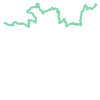

In [6]:
geostages_smooth = wrc.GeoTools.smooth_geojson_route(geostages.iloc[2:4])
geostages_smooth["num_coords"] = geostages_smooth.geometry.apply(
    lambda geom: len(geom.coords) if geom else 0
)
print(geostages_smooth["num_coords"])
geostages_smooth.iloc[0].geometry

2    2620
3    2860
Name: num_coords, dtype: int64


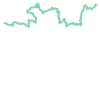

In [7]:
geostages_enhanced = wrc.GeoTools.enhance_route_resolution_osm(geostages.iloc[2:4])
geostages_enhanced["num_coords"] = geostages_enhanced.geometry.apply(
    lambda geom: len(geom.coords) if geom else 0
)
print(geostages_enhanced["num_coords"])
geostages_enhanced.iloc[0].geometry

In [13]:
wrc.GeoTools.simple_stage_map(geostages)

Map(center=[np.float64(27.948588968969), np.float64(-15.616814692003)], controls=(ZoomControl(options=['positi…

In [14]:
wrc.GeoTools.simple_stage_map(geostages_enhanced)

Map(center=[np.float64(27.9647048), np.float64(-15.66002975)], controls=(ZoomControl(options=['position', 'zoo…

In [21]:
ox.utils_geo.bbox_from_point((28.0, -15.7), dist=500)

(np.float64(-15.705092716389773),
 np.float64(27.995503398322537),
 np.float64(-15.694907283610226),
 np.float64(28.004496601677463))

In [30]:
import numpy as np
ox.features_from_bbox(
    ox.utils_geo.bbox_from_point((-15.7, 28.0), dist=1500),
    tags={"landuse": True, "building": True, "highway": True},
)

geometry  \
element id                                                              
way     256895775   LINESTRING (28.00728 -15.68916, 28.00757 -15.6...   
        500789335   POLYGON ((28.007 -15.68645, 28.00698 -15.6865,...   
        508719613   POLYGON ((28.00707 -15.68698, 28.00714 -15.686...   
        508720594   POLYGON ((28.00714 -15.68719, 28.00708 -15.687...   
        508720595   POLYGON ((28.007 -15.68701, 28.00704 -15.68703...   
...                                                               ...   
        1094007086  POLYGON ((28.00596 -15.6873, 28.00591 -15.6873...   
        1094007087  POLYGON ((28.00766 -15.6868, 28.00772 -15.6868...   
        1094007088  POLYGON ((28.00785 -15.68651, 28.00781 -15.686...   
        1094007089  POLYGON ((28.00815 -15.68664, 28.00816 -15.686...   
        1094007090  POLYGON ((28.00812 -15.68658, 28.00813 -15.686...   

                         highway  surface building  
element id                                          
way     256895775   unclassified  unpaved      NaN  
        500789335            NaN      NaN      yes  
        508719613            NaN      NaN      yes  
        508720594            NaN      NaN      yes  
        508720595            NaN      NaN      yes  
...                          ...      ...      ...  
        1094007086           NaN      NaN      yes  
        1094007087           NaN      NaN      yes  
        1094007088           NaN      NaN      yes  
        1094007089           NaN      NaN      yes  
        1094007090           NaN      NaN      yes  

[67 rows x 4 columns]